In [5]:
from route_shape_process_scripts import get_most_used_shape_id_per_direction, calc_distance
import pandas as pd
import matplotlib.pyplot as plt
import boto3
from os import listdir
from os.path import isfile, join
import io
import time
import numpy as np
import math
%matplotlib inline
%load_ext autoreload
%autoreload 2

!date
!whoami

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Wed Jun 12 22:41:53 PDT 2019
benjaminmalnor


# point this to your local copy of combined GTFS files --- see notebook `gtfs-realtime/route_shape_process/01_gtfs_transform.ipynb` 

In [6]:
#if you ran notebook 01_gtfs this path should be correct
gtfs_merge_file_path = "../data/gtfs_merge/"
agg_filename = [f for f in listdir(gtfs_merge_file_path) if isfile(join(gtfs_merge_file_path, f)) 
                and 'agg' in f][0]
routes_filename = [f for f in listdir(gtfs_merge_file_path) if isfile(join(gtfs_merge_file_path, f)) 
                and 'routes' in f][0]
shapes_filename = [f for f in listdir(gtfs_merge_file_path) if isfile(join(gtfs_merge_file_path, f)) 
                and 'shapes' in f][0]
trips_filename = [f for f in listdir(gtfs_merge_file_path) if isfile(join(gtfs_merge_file_path, f)) 
                and 'trips' in f][0]

In [7]:
full_routes_gtfs = pd.read_csv(f"{gtfs_merge_file_path}{routes_filename}", low_memory=False)
full_trip_stop_schedule = pd.read_csv(f"{gtfs_merge_file_path}{agg_filename}", low_memory=False)

In [8]:
#create a quick dictionary to convert route short name (easier to remember) with route_id
route_name_to_id_dict = dict(zip(full_routes_gtfs.route_short_name.tolist(),
                                full_routes_gtfs.route_id.tolist()))

# pick a route and direction

In [9]:
route_of_interest = "7"
direction_of_interest = 0
route_id = route_name_to_id_dict[route_of_interest]
shape_id, trip_headsign = get_most_used_shape_id_per_direction(full_trip_stop_schedule, 
                                                               route_id, 
                                                               direction_of_interest)

# generate the file_name and key to pull the transformed data down from AWS S3

In [10]:
base_key = "route_shape_files/"
csv_name = 'transformed/route_{}_{}_shape_{}_node_trips_w_nearest_2018-08-15_2018-12-11.csv'.format(
                                                route_of_interest,
                                                "".join(trip_headsign.replace("/","-").split(" ")) ,
                                                shape_id)

file_key = base_key+csv_name
file_key

'route_shape_files/transformed/route_7_RainierBeachViaRainierAveS_shape_21007003_node_trips_w_nearest_2018-08-15_2018-12-11.csv'

# Import file from S3

In [11]:
s3 = boto3.client("s3")
bucket_name = "malnor.seattle.bustime"
s3_object = s3.get_object(Bucket=bucket_name, Key=file_key)
unpacked_positions_full = pd.read_csv(io.BytesIO(s3_object['Body'].read()))

# remove far away points and backwards observations

In [12]:
unpacked_positions_clean = unpacked_positions_full\
            [(unpacked_positions_full['distance_btw_veh_and_shape']<=100)]

# select peak hours and day of week of interest

In [13]:
#Metro “Peak” hours: 6 – 9 a.m. and 3 – 7 p.m
hours_of_interest = [6,7,8,9,15, 16, 17, 18, 19]
#dow - Monday = 0
dow_of_interest = [0,1,2,3,4]
unpacked_positions_clean_hours = unpacked_positions_clean\
                                        [(unpacked_positions_clean['hour'].isin(hours_of_interest))&
                                        (unpacked_positions_clean['dow'].isin(dow_of_interest))]

# plot average speed across the route

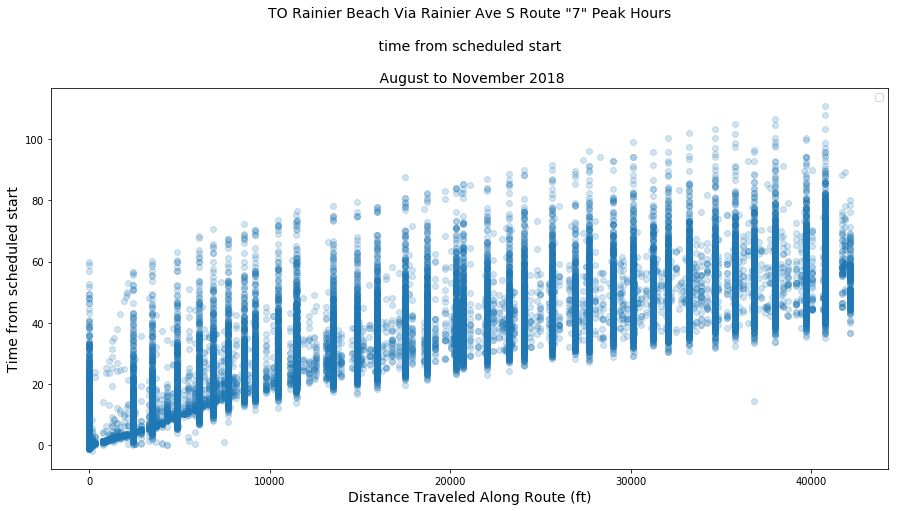

In [14]:
fig, ax = plt.subplots(figsize=(15,7))
y = unpacked_positions_clean_hours['actual_time_from_scheduled_start'].values
x = unpacked_positions_clean_hours['shape_dist_traveled'].values

ax.scatter(x, y, alpha=0.2)

ax.set_ylabel("Time from scheduled start", fontsize=14)
ax.set_xlabel("Distance Traveled Along Route (ft)", fontsize=14)
title_str = ("""TO {} Route \"{}\" Peak Hours
                \n time from scheduled start 
                \n August to November 2018""".format(trip_headsign,
                                                    route_of_interest, hours_of_interest))
ax.legend()
_ = ax.set_title(title_str, fontsize=14)

# try below if you have `ipywidgets` installed

In [15]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [17]:
@interact
def show_trip_speeds(x=list(unpacked_positions_clean_hours['month_day_trip_veh'].unique())):
    onetrip_df = unpacked_positions_clean_hours[unpacked_positions_clean_hours['month_day_trip_veh']==x]\
            [['month_day_trip_veh', 'shape_dist_traveled', 
           'actual_time_from_scheduled_start']]
    fig, ax = plt.subplots(figsize=(15,7))
    y = onetrip_df['actual_time_from_scheduled_start'].values
    x_plot = onetrip_df['shape_dist_traveled'].values
    
    ax.plot(x_plot, y)

    ax.set_ylabel("Time from scheduled start", fontsize=14)
    ax.set_xlabel("Stops Along Route", fontsize=14)
    title_str = ("""{} TO {} \"{}\" Peak Hours
                    \n time from scheduled start 
                    \n August to November 2018""".format(x, trip_headsign,
                                                        route_of_interest, hours_of_interest))
    ax.legend()
    _ = ax.set_title(title_str, fontsize=14)
    print(x)

interactive(children=(Dropdown(description='x', options=('2018_8_31_39478016_4543', '2018_8_31_39478287_4538',…